## 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
import wandb
import seaborn as sns
from sklearn.model_selection import KFold
import time

Loading Wine-QT Data

In [98]:
data = pd.read_csv('WineQT.csv')
labels = data['quality']

data = data.drop(columns=['quality', 'Id'])
# get feature_names of data
feature_names = data.columns

data = data.values
labels = labels.values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
data = imputer.fit_transform(data)

# Normalising the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Standardising the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# One hot encoding the labels
enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1, 1)).toarray()

# Splitting the dataset into train(70%), validation(15%) and test(15%) sets
x_train_wine, x_temp, y_train_wine, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
x_valid_wine, x_test_wine, y_valid_wine, y_test_wine = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Loading Housing Data

In [3]:
house_data = pd.read_csv('HousingData.csv')
labels_house = house_data['MEDV']
house_data = house_data.drop(columns=['MEDV'])

house_data = house_data.values
labels_house = labels_house.values

imputer = SimpleImputer(strategy='mean')
house_data = imputer.fit_transform(house_data)

scaler = StandardScaler()
house_data = scaler.fit_transform(house_data)

scaler = MinMaxScaler()
house_data = scaler.fit_transform(house_data)

x_train_house, x_temp, y_train_house, y_temp = train_test_split(house_data, labels_house, test_size=0.3, random_state=42)
x_valid_house, x_test_house, y_valid_house, y_test_house = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

y_train_house_new = y_train_house.reshape(-1, 1)
y_valid_house_new = y_valid_house.reshape(-1, 1)
y_test_house_new = y_test_house.reshape(-1, 1)

### List 1 Models

Decision-Tree Classifier

In [4]:
class DTC:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.dt = None

    def fit(self, x, y):
        decision_tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        y = np.argmax(y, axis=1)
        decision_tree.fit(x, y)
        self.dt = decision_tree

    def predict2(self, x):
        return self.dt.predict(x)
    
    def predict1(self, x):
        pred = self.dt.predict_proba(x)
        #print(pred.shape)
        return pred

    def test(self, x, y):   
        pred = self.predict2(x)
        y = np.argmax(y, axis=1)
        
        acc = accuracy_score(y, pred)
        f1 = f1_score(y, pred, average='macro')
        precision = precision_score(y, pred, average='macro', zero_division=0)
        recall = recall_score(y, pred, average='macro', zero_division=0)
        
                
        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

Logistic Regressor

In [5]:
class LogisticRegressor:
    def __init__(self, num_classes, num_features, learning_rate, num_iterations):
        self.num_classes = num_classes
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

        # Initialize weights and biases
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros(self.num_classes)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]  
        return -1/m * np.sum(y_true * np.log(y_pred))

    def gradient_descent(self, X, y):
        m = X.shape[0]  

        # Forward pass
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)

        # Compute the gradient
        dz = y_pred - y
        dw = 1/m * np.dot(X.T, dz)
        db = 1/m * np.sum(dz, axis=0, keepdims=True)

        return dw, db, y_pred

    def fit(self, X, y):
        for i in range(self.num_iterations):
            dw, db, y_pred = self.gradient_descent(X, y)

            # Update the weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * np.squeeze(db)
                
    def predict1(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)
    
    def predict2(self, X):
        y_pred = self.predict1(X)
        return np.argmax(y_pred, axis=1)
    
    def test(self, X, y):
        y_pred = self.predict2(X)
        y_true = np.argmax(y, axis=1)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

Activation functions

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

MLP Classifier

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss

class MlpClassifier:
    def __init__(self, input_size, output_size, num_layers, learning_rate, epochs, neurons_per_layer, activation_function, optimizer, num_samples):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_hidden_layers = num_layers
        self.epochs = epochs
        self.batch_size = None
        self.neurons_per_layer = neurons_per_layer
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.num_samples = num_samples

        self.initialize_parameters()

    def initialize_parameters(self):
        if self.optimizer == 'sgd':
            self.batch_size = 1
        elif self.optimizer == 'mini-batch':
            self.batch_size = 32
        else:
            self.batch_size = self.num_samples

        self.weights = []
        self.biases = []

        # Input layer
        self.weights.append(np.random.randn(self.input_size, self.neurons_per_layer))
        self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Hidden layers
        for i in range(1, self.num_hidden_layers):
            self.weights.append(np.random.randn(self.neurons_per_layer, self.neurons_per_layer))
            self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Output layer
        self.weights.append(np.random.randn(self.neurons_per_layer, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def forward_propagation(self, x):
        self.activations = []
        self.z_values = []

        a = x
        self.activations.append(a)

        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if self.activation_function == 'sigmoid':
                a = sigmoid(z)
            elif self.activation_function == 'relu':
                a = relu(z)
            else:
                a = tanh(z)

            self.activations.append(a)

        # Output layer
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        a = softmax(z)

        self.z_values.append(z)
        self.activations.append(a)

        return a

    def backward_propagation(self, x, y, output):
        m = x.shape[0]
        delta = output - y

        self.delta_weights = [0] * (self.num_hidden_layers + 1)
        self.delta_biases = [0] * (self.num_hidden_layers + 1)

        self.delta_weights[-1] = 1/m * np.dot(self.activations[-2].T, delta)
        self.delta_biases[-1] = 1/m * np.sum(delta, axis=0, keepdims=True)

        for i in range(self.num_hidden_layers - 1, 0, -1):
            if self.activation_function == 'sigmoid':
                delta = np.dot(delta, self.weights[i + 1].T) * sigmoid_derivative(self.z_values[i])
            elif self.activation_function == 'relu':
                delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            else:
                delta = np.dot(delta, self.weights[i + 1].T) * tanh_derivative(self.z_values[i])
        
            self.delta_weights[i] = 1/m * np.dot(self.activations[i].T, delta)
            self.delta_biases[i] = 1/m * np.sum(delta, axis=0, keepdims=True)

        if self.activation_function == 'sigmoid':
            delta = np.dot(delta, self.weights[1].T) * sigmoid_derivative(self.z_values[0])
        elif self.activation_function == 'relu':
            delta = np.dot(delta, self.weights[1].T) * relu_derivative(self.z_values[0])
        else:
            delta = np.dot(delta, self.weights[1].T) * tanh_derivative(self.z_values[0])
        
        self.delta_weights[0] = 1/m * np.dot(x.T, delta)
        self.delta_biases[0] = 1/m * np.sum(delta, axis=0, keepdims=True)

    def gradient_descent(self):
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] -= self.learning_rate * self.delta_weights[i]
            self.biases[i] -= self.learning_rate * np.squeeze(self.delta_biases[i])

    def loss(self, y_true, y_pred):
        return -1/y_true.shape[0] * np.sum(y_true * np.log(y_pred))

    def fit(self, X, y):
        for epoch in range(self.epochs):
            for i in range(0, self.num_samples, self.batch_size):
                x_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                    
                output = self.forward_propagation(x_batch)

                self.backward_propagation(x_batch, y_batch, output)
                self.gradient_descent()

    def predict1(self, x):
        return self.forward_propagation(x)
    
    def predict2(self, x):
        y_pred = np.argmax(self.predict1(x), axis=1)
        return y_pred

    def test(self, x, y):
        y_pred = self.forward_propagation(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y, axis=1)
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro')

        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score: ", f1)

Decision-Tree Regressor

In [8]:
class DTR:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.dt = None

    def fit(self, x, y):
        decision_tree = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        decision_tree.fit(x, y)
        self.dt = decision_tree

    def predict(self, x):
        return self.dt.predict(x)

    def loss(self, y, pred):
        return mean_squared_error(y, pred)

    def test(self, x, y):
        pred = self.predict(x)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)
        
        print('MSE: ', mse)
        print('RMSE: ', np.sqrt(mse))
        print('R2 score: ', r2)

Linear Regressor

In [9]:
class LinearRegressor:
    def __init__(self, learning_rate, num_iterations):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def fit(self, x, y):
        num_samples = x.shape[0]
        num_features = x.shape[1]

        self.weights = np.zeros(num_features)
        self.bias = 0

        for i in range(self.num_iterations):
            y_pred = np.dot(x, self.weights) + self.bias
            y_pred = y_pred.reshape(-1, 1)

            dw = 1/num_samples * np.dot(x.T, (y_pred - y))
            db = 1/num_samples * np.sum(y_pred - y)

            dw = dw.reshape(-1)
            clip = 1
            dw = np.clip(dw, -clip, clip)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def loss(self, y, pred):
        return mean_squared_error(y, pred)

    def predict(self, x):
        return np.dot(x, self.weights) + self.bias

    def test(self, x, y):
        pred = self.predict(x)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)
        
        print('MSE: ', mse)
        print('RMSE: ', np.sqrt(mse))
        print('R2 score: ', r2)

MLP Regressor

In [10]:
class MlpRegressor:
    def __init__(self, input_size, output_size, num_layers, learning_rate, epochs, neurons_per_layer, activation_function, optimizer, num_samples):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_hidden_layers = num_layers
        self.epochs = epochs
        self.batch_size = None
        self.neurons_per_layer = neurons_per_layer
        self.activation_function = activation_function
        self.optimizer = optimizer 
        self.num_samples = num_samples

        self.initialize_parameters()

    def initialize_parameters(self):
        if self.optimizer == 'sgd':
            self.batch_size = 1
        elif self.optimizer == 'mini-batch':
            self.batch_size = 10
        else:
            self.batch_size = self.num_samples

        self.weights = []
        self.biases = []

        # Input layer
        self.weights.append(np.random.randn(self.input_size, self.neurons_per_layer))
        self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Hidden layers
        for i in range(1, self.num_hidden_layers):
            self.weights.append(np.random.randn(self.neurons_per_layer, self.neurons_per_layer))
            self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Output layer
        self.weights.append(np.random.randn(self.neurons_per_layer, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def forward_propagation(self, x):
        self.activations = []
        self.z_values = []

        a = x
        self.activations.append(a)

        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if self.activation_function == 'sigmoid':
                a = sigmoid(z)
            elif self.activation_function == 'relu':
                a = relu(z)
            else:
                a = tanh(z)

            self.activations.append(a)

        # Output layer
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        a = z
        self.z_values.append(z)
        self.activations.append(a)

        return a

    def backward_propagation(self, x, y, output):
        m = x.shape[0]
        delta = output - y

        self.delta_weights = [0] * (self.num_hidden_layers + 1)
        self.delta_biases = [0] * (self.num_hidden_layers + 1)

        self.delta_weights[-1] = 1/m * np.dot(self.activations[-2].T, delta)
        self.delta_biases[-1] = 1/m * np.sum(delta, axis=0, keepdims=True)

        for i in range(self.num_hidden_layers - 1, 0, -1):
            if self.activation_function == 'sigmoid':
                delta = np.dot(delta, self.weights[i + 1].T) * sigmoid_derivative(self.z_values[i])
            elif self.activation_function == 'relu':
                delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            else:
                delta = np.dot(delta, self.weights[i + 1].T) * tanh_derivative(self.z_values[i])
        
            self.delta_weights[i] = 1/m * np.dot(self.activations[i].T, delta)
            self.delta_biases[i] = 1/m * np.sum(delta, axis=0, keepdims=True)

        if self.activation_function == 'sigmoid':
            delta = np.dot(delta, self.weights[1].T) * sigmoid_derivative(self.z_values[0])
        elif self.activation_function == 'relu':
            delta = np.dot(delta, self.weights[1].T) * relu_derivative(self.z_values[0])
        else:
            delta = np.dot(delta, self.weights[1].T) * tanh_derivative(self.z_values[0])
        
        self.delta_weights[0] = 1/m * np.dot(x.T, delta)
        self.delta_biases[0] = 1/m * np.sum(delta, axis=0, keepdims=True)

    def gradient_descent(self):
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] -= self.learning_rate * self.delta_weights[i]
            self.biases[i] -= self.learning_rate * np.squeeze(self.delta_biases[i])

    def loss(self, y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                x_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]

                output = self.forward_propagation(x_batch)
                self.backward_propagation(x_batch, y_batch, output)
                self.gradient_descent()

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred.flatten()
    
    def test(self, X, y):
        y_pred = self.forward_propagation(X)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, y_pred)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

### 3.2

Bagging Classifier

In [11]:
class BaggingClassifier:
    def __init__(self, base_estimator, num_estimators, fraction, bootstrap, voting, num_classes):
        self.base_estimator = base_estimator
        self.num_estimators = num_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.num_samples = None
        self.num_classes = num_classes

        self.estimators = []

    def fit(self, X, y):
        self.num_samples = int(self.fraction * X.shape[0])
        
        for i in range(self.num_estimators):
            if self.bootstrap:
                indices = np.random.choice(X.shape[0], size=self.num_samples, replace=True)
            else:
                indices = np.random.choice(X.shape[0], size=self.num_samples, replace=False)

            x_train = X[indices]
            y_train = y[indices]

            estimator = self.base_estimator
            estimator.fit(x_train, y_train)
            self.estimators.append(estimator)

    def predict(self, X):
        if self.voting == 'hard':
            predictions = np.zeros((X.shape[0], self.num_estimators))

            for i in range(self.num_estimators):
                predictions[:, i] = self.estimators[i].predict2(X)

            predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=predictions)

        else:
            pred = self.estimators[0].predict1(X)
            predictions = np.zeros((X.shape[0], self.num_estimators, pred.shape[1]))

            for i in range(self.num_estimators):
                predictions[:, i, :] = self.estimators[i].predict1(X)

            predictions = np.mean(predictions, axis=1)
            predictions = np.argmax(predictions, axis=1)

        return predictions

    def scores(self, X, y):
        predictions = self.predict(X)
        y = np.argmax(y, axis=1)

        acc = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions, average='macro')
        precision = precision_score(y, predictions, average='macro', zero_division=0)
        recall = recall_score(y, predictions, average='macro', zero_division=0)
        
        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

Decision-Tree Classification

In [18]:
print("Decision Tree Classifier with Bagging")
print("Hard Voting ======================")
base_estimator = DTC(max_depth=5, max_features=5, criterion='entropy')
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores:")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores:")
model.scores(x_test_wine, y_test_wine)

print()

print("Soft Voting ======================")
base_estimator = DTC(max_depth=5, max_features=5, criterion='entropy')
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'soft', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores:")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores:")
model.scores(x_test_wine, y_test_wine)

print()

print("Decision Tree Classifier without Bagging")
model = DTC(max_depth=5, max_features=5, criterion='entropy')
model.fit(x_train_wine, y_train_wine)
print("Validation scores:")
model.test(x_valid_wine, y_valid_wine)
print("Test scores:")
model.test(x_test_wine, y_test_wine)

Decision Tree Classifier with Bagging
Hard Voting ======================
Validation scores:
Accuracy:  0.543859649122807
Precision:  0.2532210638866613
Recall:  0.2440096906942785
F1 score:  0.24803272243392002
Test scores:
Accuracy:  0.5
Precision:  0.22532578445073517
Recall:  0.23761428598029907
F1 score:  0.23034328365601306

Soft Voting ======================
Validation scores:
Accuracy:  0.5321637426900585
Precision:  0.2715908450307232
Recall:  0.2357958316739679
F1 score:  0.23763736263736265
Test scores:
Accuracy:  0.46511627906976744
Precision:  0.19259590538660307
Recall:  0.18805653315457238
F1 score:  0.1832209706461203

Decision Tree Classifier without Bagging
Validation scores:
Accuracy:  0.6081871345029239
Precision:  0.36898145113718295
Recall:  0.3729390681003585
F1 score:  0.36905702992659517
Test scores:
Accuracy:  0.622093023255814
Precision:  0.39537684537684537
Recall:  0.3188490400908701
F1 score:  0.3386457412319481


Logistic Regression

In [23]:
print("Logistic Regressor with Bagging")
print("Hard Voting ======================")
base_estimator = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("Soft Voting ======================")
base_estimator = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'soft', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("Logistic Regressor without Bagging")
model = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.test(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.test(x_test_wine, y_test_wine)

Logistic Regressor with Bagging
Hard Voting ======================
Validation scores: 
Accuracy:  0.6491228070175439
Precision:  0.4002411091018686
Recall:  0.36979291119076063
F1 score:  0.37508786015621143
Test scores: 
Accuracy:  0.6162790697674418
Precision:  0.3426289157996475
Recall:  0.3343410982626669
F1 score:  0.33403958005184997

Soft Voting ======================
Validation scores: 
Accuracy:  0.6140350877192983
Precision:  0.37085470085470085
Recall:  0.34476304261250496
F1 score:  0.34552343459906487
Test scores: 
Accuracy:  0.5813953488372093
Precision:  0.31743456629894007
Recall:  0.3140561979777666
F1 score:  0.313036282699428

Logistic Regressor without Bagging
Validation scores: 
Accuracy:  0.6374269005847953
Precision:  0.39493506493506497
Recall:  0.36334129828753486
F1 score:  0.36970750303973887
Test scores: 
Accuracy:  0.627906976744186
Precision:  0.342885872297637
Recall:  0.3305915870621753
F1 score:  0.3291936978683967


MLP Classification

In [24]:
print("MLP Classifier with Bagging")
print("Hard Voting ======================")
base_estimator = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("Soft Voting ======================")
base_estimator = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
model = BaggingClassifier(base_estimator, 10, 0.75, True, 'soft', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("MLP Classifier without Bagging")
model = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.test(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.test(x_test_wine, y_test_wine)

MLP Classifier with Bagging
Hard Voting ======================
Validation scores: 
Accuracy:  0.5789473684210527
Precision:  0.3489168254793255
Recall:  0.46384242665604675
F1 score:  0.3763116970926302
Test scores: 
Accuracy:  0.5523255813953488
Precision:  0.26535087719298245
Recall:  0.27987821909390537
F1 score:  0.27142716486978785

Soft Voting ======================
Validation scores: 
Accuracy:  0.6198830409356725
Precision:  0.3763301214914118
Recall:  0.3896057347670251
F1 score:  0.37844745182874673
Test scores: 
Accuracy:  0.5697674418604651
Precision:  0.25876051162462016
Recall:  0.27830475020017503
F1 score:  0.2650208105841207

MLP Classifier without Bagging
Validation scores: 
Accuracy:  0.6783625730994152
Precision:  0.4029473684210526
Recall:  0.3997311827956989
F1 score:  0.398672342150603
Test scores: 
Accuracy:  0.5930232558139535
Precision:  0.27827611664820967
Recall:  0.2828408096381952
F1 score:  0.28004315443187694


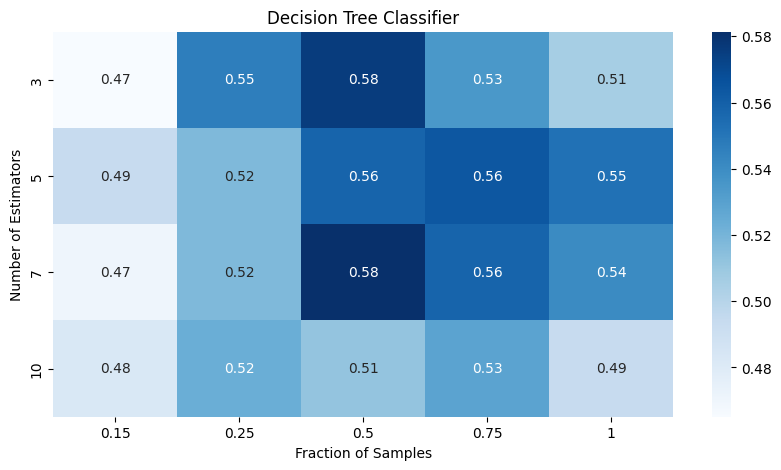

In [24]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = DTC(max_depth=5, max_features=5, criterion='entropy')
        model = BaggingClassifier(base_estimator, n_estimators[i], fraction[j], True, 'hard', y_train_wine.shape[1])
        model.fit(x_train_wine, y_train_wine)
        predictions = model.predict(x_test_wine)
        y_test_wine_new = np.argmax(y_test_wine, axis=1)
        acc[i][j] = accuracy_score(y_test_wine_new, predictions)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('Decision Tree Classifier')
plt.show()

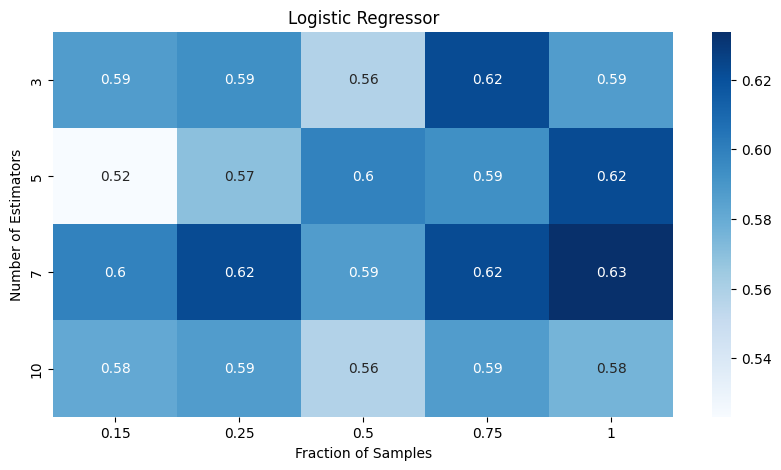

In [27]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
        model = BaggingClassifier(base_estimator, n_estimators[i], fraction[j], True, 'hard', y_train_wine.shape[1])
        model.fit(x_train_wine, y_train_wine)
        predictions = model.predict(x_test_wine)
        y_test_wine_new = np.argmax(y_test_wine, axis=1)
        acc[i][j] = accuracy_score(y_test_wine_new, predictions)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('Logistic Regressor')
plt.show()

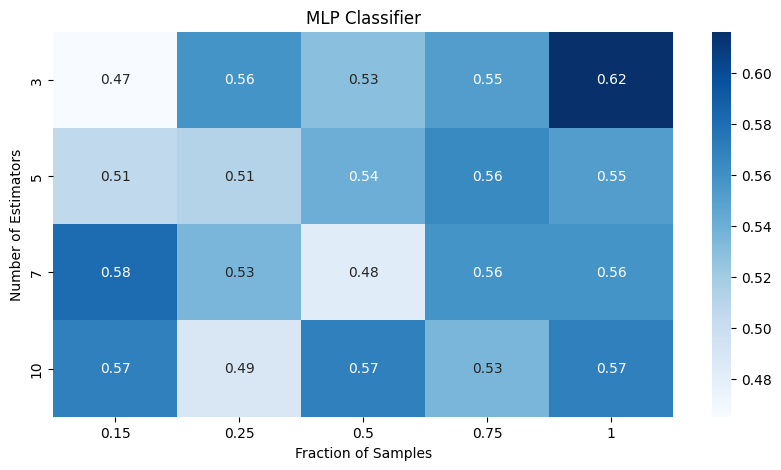

In [26]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
        model = BaggingClassifier(base_estimator, n_estimators[i], fraction[j], True, 'hard', y_train_wine.shape[1])
        model.fit(x_train_wine, y_train_wine)
        predictions = model.predict(x_test_wine)
        y_test_wine_new = np.argmax(y_test_wine, axis=1)
        acc[i][j] = accuracy_score(y_test_wine_new, predictions)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('MLP Classifier')
plt.show()

In [64]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]
base_estimators = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
base_estimators_names = ['Decision Tree Classifier', 'Logistic Regressor', 'MLP Classifier']
bootstrap = [True, False]
voting = ['hard', 'soft']

best_estimator = None
best_estimator_name = None
best_n_estimators = None
best_fraction = None
best_bootstrap = None
best_voting = None

best_acc = 0

for i in range(len(base_estimators)):
    for j in range(len(n_estimators)):
        for k in range(len(fraction)):
            for l in range(len(bootstrap)):
                for m in range(len(voting)):
                    model = BaggingClassifier(base_estimators[i], n_estimators[j], fraction[k], bootstrap[l], voting[m], y_train_wine.shape[1])
                    model.fit(x_train_wine, y_train_wine)
                    predictions = model.predict(x_valid_wine)
                    y_valid_wine_new = np.argmax(y_valid_wine, axis=1)
                    acc = accuracy_score(y_valid_wine_new, predictions)
                    print(acc)

                    if acc > best_acc:
                        best_acc = acc
                        best_estimator = base_estimators[i]
                        best_estimator_name = base_estimators_names[i]
                        best_n_estimators = n_estimators[j]
                        best_fraction = fraction[k]
                        best_bootstrap = bootstrap[l]
                        best_voting = voting[m]

print("Best estimator: ", best_estimator_name)
print("Best n_estimators: ", best_n_estimators)
print("Best fraction: ", best_fraction)
print("Best bootstrap: ", best_bootstrap)
print("Best voting: ", best_voting)

0.4327485380116959
0.12280701754385964
0.49707602339181284
0.5321637426900585
0.49122807017543857
0.47368421052631576
0.543859649122807
0.5321637426900585
0.52046783625731
0.49122807017543857
0.6081871345029239
0.5497076023391813
0.5964912280701754
0.5321637426900585
0.6140350877192983
0.5730994152046783
0.543859649122807
0.6023391812865497
0.5789473684210527
0.6374269005847953
0.5497076023391813
0.5263157894736842
0.5789473684210527
0.17543859649122806
0.47368421052631576
0.5029239766081871
0.5321637426900585
0.5380116959064327
0.4853801169590643
0.49707602339181284
0.5497076023391813
0.6374269005847953
0.5380116959064327
0.5730994152046783
0.5964912280701754
0.5964912280701754
0.6081871345029239
0.5964912280701754
0.6374269005847953
0.6374269005847953
0.49707602339181284
0.13450292397660818
0.5789473684210527
0.5087719298245614
0.49707602339181284
0.5730994152046783
0.6374269005847953
0.5555555555555556
0.5730994152046783
0.5964912280701754
0.6198830409356725
0.52046783625731
0.51461

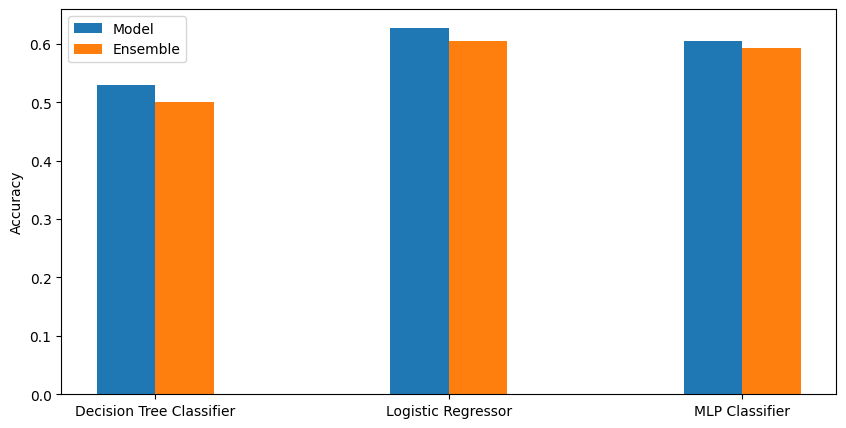

In [70]:
acc_model = []
acc_ensemble = []

base_estimator = DTC(max_depth=5, max_features=5, criterion='entropy')
model = BaggingClassifier(base_estimator, 7, 0.5, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_ensemble.append(accuracy_score(y_test_wine_new, predictions))

model = DTC(max_depth=5, max_features=5, criterion='entropy')
model.fit(x_train_wine, y_train_wine)
predictions = model.predict2(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_model.append(accuracy_score(y_test_wine_new, predictions))

base_estimator = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model = BaggingClassifier(base_estimator, 7, 1, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_ensemble.append(accuracy_score(y_test_wine_new, predictions))

model = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model.fit(x_train_wine, y_train_wine)
predictions = model.predict2(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_model.append(accuracy_score(y_test_wine_new, predictions))

base_estimator = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
model = BaggingClassifier(base_estimator, 3, 1, True, 'hard', y_train_wine.shape[1])
model.fit(x_train_wine, y_train_wine)
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_ensemble.append(accuracy_score(y_test_wine_new, predictions))

model = MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])
model.fit(x_train_wine, y_train_wine)
predictions = model.predict2(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_model.append(accuracy_score(y_test_wine_new, predictions))

plt.figure(figsize=(10, 5))
plt.bar(np.arange(3), acc_model, width=0.2, label='Model')
plt.bar(np.arange(3) + 0.2, acc_ensemble, width=0.2, label='Ensemble')
plt.xticks(np.arange(3) + 0.1, ['Decision Tree Classifier', 'Logistic Regressor', 'MLP Classifier'])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Bagging Regressor

In [12]:
class BaggingRegressor:
    def __init__(self, base_estimator, num_estimators, fraction, bootstrap, voting):
        self.base_estimator = base_estimator
        self.num_estimators = num_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.num_samples = None

        self.estimators = []

    def fit(self, X, y):
        self.num_samples = int(self.fraction * X.shape[0])
        
        for i in range(self.num_estimators):
            if self.bootstrap:
                indices = np.random.choice(X.shape[0], size=self.num_samples, replace=True)
            else:
                indices = np.random.choice(X.shape[0], size=self.num_samples, replace=False)

            x_train = X[indices]
            y_train = y[indices]

            estimator = self.base_estimator
            estimator.fit(x_train, y_train)
            self.estimators.append(estimator)

    def predict(self, X, y):
        predictions = np.zeros((X.shape[0], self.num_estimators))

        for i in range(self.num_estimators):
            predictions[:, i] = self.estimators[i].predict(X)

        if self.voting == 'hard':
            predictions = np.apply_along_axis(lambda x: np.mean(x.astype(int)), axis=1, arr=predictions)
            
        else:
            loss = np.zeros(self.num_estimators)
            for i in range(self.num_estimators):
                loss[i] = self.estimators[i].loss(y, predictions[:, i])

            weights = 1 / loss
            predictions = np.average(predictions, axis=1, weights=weights)

        return predictions

    def scores(self, X, y):
        predictions = self.predict(X, y)

        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, predictions)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

Decision-Tree Regression

In [123]:
print("Decision Tree Regressor with Bagging")
print("Hard Voting ======================")
base_estimator = DTR(max_depth=5, max_features=5, criterion='squared_error')
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'hard')
model.fit(x_train_house, y_train_house_new)
print("Validation scores:")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores:")
model.scores(x_test_house, y_test_house_new)

print()

print("Soft Voting ======================")
base_estimator = DTR(max_depth=5, max_features=5, criterion='squared_error')
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_house, y_train_house_new)
print("Validation scores:")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores:")
model.scores(x_test_house, y_test_house_new)

print()

print("Decision Tree Regressor without Bagging")
model = DTR(max_depth=5, max_features=5, criterion='squared_error')
model.fit(x_train_house, y_train_house_new)
print("Validation scores:")
model.test(x_valid_house, y_valid_house_new)
print("Test scores:")
model.test(x_test_house, y_test_house_new)

Decision Tree Regressor with Bagging
Hard Voting ======================
Validation scores:
MSE:  29.580526315789474
RMSE:  5.438798241871956
R2 Score:  0.5735831320759539
Test scores:
MSE:  29.183684210526316
RMSE:  5.402192537343177
R2 Score:  0.6328143161607483

Soft Voting ======================
Validation scores:
MSE:  13.588417641810398
RMSE:  3.68624709451366
R2 Score:  0.8041167209465185
Test scores:
MSE:  29.923689498246702
RMSE:  5.470254975615552
R2 Score:  0.6235036566272867

Decision Tree Regressor without Bagging
Validation scores:
MSE:  17.743977161488097
RMSE:  4.212360046516453
R2 score:  0.7442124225599458
Test scores:
MSE:  28.55794213710345
RMSE:  5.343963148928279
R2 score:  0.6406873293649514


Linear Regression

In [137]:
print("Linear Regressor with Bagging")
print("Hard Voting ======================")
base_estimator = LinearRegressor(0.01, 2000)
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'hard')
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("Soft Voting ======================")
base_estimator = LinearRegressor(0.01, 2000)
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("Linear Regressor without Bagging")
model = LinearRegressor(0.01, 2000)
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.test(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.test(x_test_house, y_test_house_new)

Linear Regressor with Bagging
Hard Voting ======================
Validation scores: 
MSE:  26.83578947368421
RMSE:  5.180327158943169
R2 Score:  0.6131497738250402
Test scores: 
MSE:  37.67578947368422
RMSE:  6.138060725806175
R2 Score:  0.5259676460901189

Soft Voting ======================
Validation scores: 
MSE:  26.633342490045738
RMSE:  5.1607501867505405
R2 Score:  0.6160681400421317
Test scores: 
MSE:  39.79659502897986
RMSE:  6.3084542503675065
R2 Score:  0.4992839199199176

Linear Regressor without Bagging
Validation scores: 
MSE:  26.096334263866883
RMSE:  5.108457131450442
R2 score:  0.6238093601750003
Test scores: 
MSE:  37.78234170040765
RMSE:  6.146734230500588
R2 score:  0.524627018499997


MLP Regression

In [56]:
print("MLP Regressor with Bagging")
print("Hard Voting ======================")
base_estimator = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'hard')
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("Soft Voting ======================")
base_estimator = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model = BaggingRegressor(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("MLP Regressor without Bagging")
model = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.test(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.test(x_test_house, y_test_house_new)

MLP Regressor with Bagging
Hard Voting ======================
Validation scores: 
MSE:  9.975263157894737
RMSE:  3.1583640002214337
R2 Score:  0.856202001712285
Test scores: 
MSE:  26.538947368421056
RMSE:  5.151596584401874
R2 Score:  0.6660900841870832

Soft Voting ======================
Validation scores: 
MSE:  11.082980848194163
RMSE:  3.3291111198327643
R2 Score:  0.8402337426286253
Test scores: 
MSE:  24.516408819157732
RMSE:  4.951404731907677
R2 Score:  0.6915374264398695

MLP Regressor without Bagging
Validation scores: 
MSE:  35.33959126679025
RMSE:  5.944711201293991
R2 Score:  0.49056356669161294
Test scores: 
MSE:  47.047819206267434
RMSE:  6.859141287819302
R2 Score:  0.40804986979102076


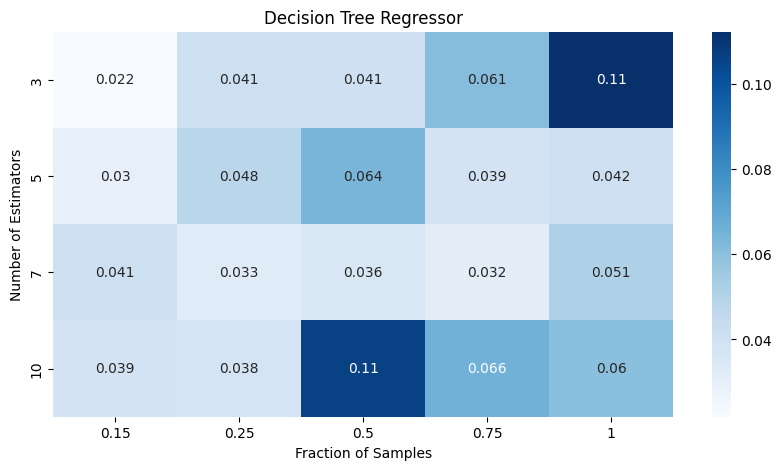

In [28]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = DTR(max_depth=5, max_features=5, criterion='squared_error')
        model = BaggingRegressor(base_estimator, n_estimators[i], fraction[j], True, 'hard')
        model.fit(x_train_house, y_train_house_new)
        predictions = model.predict(x_test_house, y_test_house_new)
        acc[i][j] = 1/mean_squared_error(y_test_house_new, predictions)

acc = acc / np.sum(acc)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('Decision Tree Regressor')
plt.show()

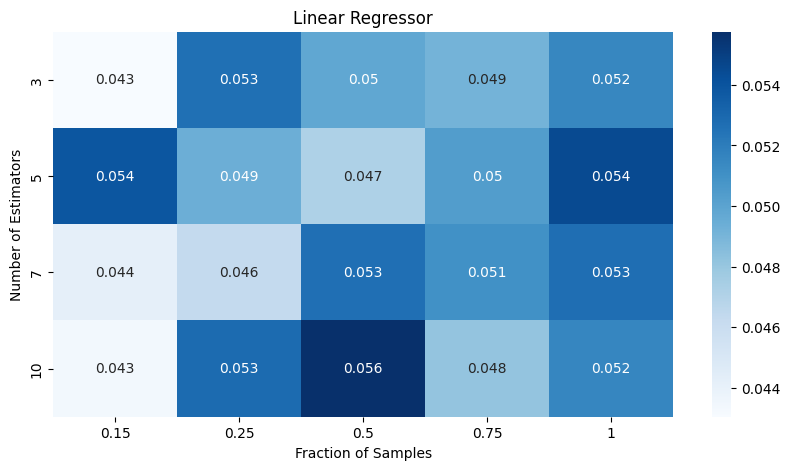

In [29]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = LinearRegressor(0.01, 2000)
        model = BaggingRegressor(base_estimator, n_estimators[i], fraction[j], True, 'hard')
        model.fit(x_train_house, y_train_house_new)
        predictions = model.predict(x_test_house, y_test_house_new)
        acc[i][j] = 1/mean_squared_error(y_test_house_new, predictions)

acc = acc / np.sum(acc)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('Linear Regressor')
plt.show()

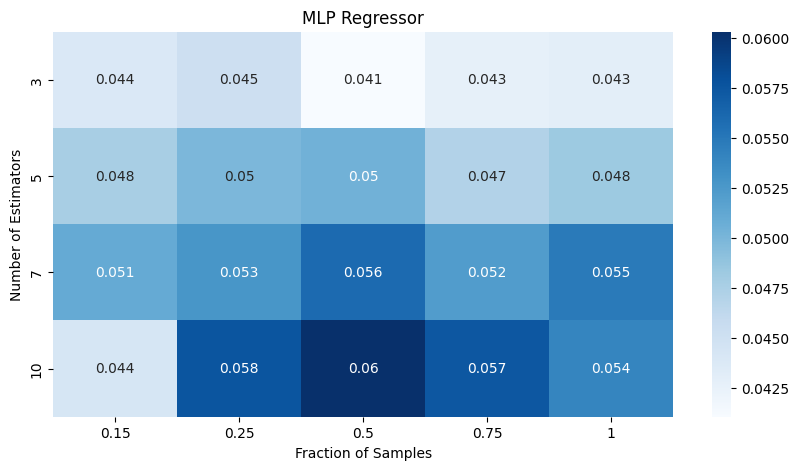

In [30]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]

acc = np.zeros((len(n_estimators), len(fraction)))

for i in range(len(n_estimators)):
    for j in range(len(fraction)):
        base_estimator = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
        model = BaggingRegressor(base_estimator, n_estimators[i], fraction[j], True, 'hard')
        model.fit(x_train_house, y_train_house_new)
        predictions = model.predict(x_test_house, y_test_house_new)
        acc[i][j] = 1/mean_squared_error(y_test_house_new, predictions)

acc = acc / np.sum(acc)

plt.figure(figsize=(10, 5))
sns.heatmap(acc, annot=True, xticklabels=fraction, yticklabels=n_estimators, cmap='Blues')
plt.xlabel('Fraction of Samples')
plt.ylabel('Number of Estimators')
plt.title('MLP Regressor')
plt.show()

In [72]:
n_estimators = [3, 5, 7, 10]
fraction = [0.15, 0.25, 0.5, 0.75, 1]
base_estimators = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
base_estimators_names = ['Decision Tree Regressor', 'Linear Regressor', 'MLP Regressor']
bootstrap = [True, False]
voting = ['hard', 'soft']

best_estimator = None
best_estimator_name = None
best_n_estimators = None
best_fraction = None
best_bootstrap = None
best_voting = None

best_loss = 100000

for i in range(len(base_estimators)):
    for j in range(len(n_estimators)):
        for k in range(len(fraction)):
            for l in range(len(bootstrap)):
                for m in range(len(voting)):
                    model = BaggingRegressor(base_estimators[i], n_estimators[j], fraction[k], bootstrap[l], voting[m])
                    model.fit(x_train_house, y_train_house_new)
                    predictions = model.predict(x_valid_house, y_valid_house_new)
                    loss = mean_squared_error(y_valid_house_new, predictions)
                    print(loss)

                    if loss < best_loss:
                        best_loss = loss
                        best_estimator = base_estimators[i]
                        best_estimator_name = base_estimators_names[i]
                        best_n_estimators = n_estimators[j]
                        best_fraction = fraction[k]
                        best_bootstrap = bootstrap[l]
                        best_voting = voting[m]

print("Best estimator: ", best_estimator_name)
print("Best n_estimators: ", best_n_estimators)
print("Best fraction: ", best_fraction)
print("Best bootstrap: ", best_bootstrap)
print("Best voting: ", best_voting)

28.917368421052636
42.2021477582846
23.935789473684213
22.116513450292395
13.383157894736842
17.25307248580398
20.080526315789474
16.106360016358277
11.977894736842106
11.255098006685477
11.15684210526316
15.542871449382442
18.07526315789474
29.59621631122118
27.659473684210532
19.908984465061295
16.488421052631583
15.426140206565089
12.393684210526317
13.884360261085135
26.209473684210526
30.318075713838155
14.548947368421056
38.51189793483338
36.02263157894736
47.837805026703656
23.56736842105263
23.810149719427244
16.041052631578953
24.253925213924756
18.891052631578944
27.2676050392573
19.0621052631579
14.824688917353622
13.072631578947368
12.299909359952633
12.28578947368421
12.647502200160707
12.322631578947368
17.175682330154327
12.559473684210525
53.60760397050937
16.87526315789474
31.483664558966858
17.27
14.35366602778314
17.238421052631576
34.54832681259477
32.485789473684214
17.208069774497318
19.919999999999998
23.060746146205606
24.004210526315784
28.921916023401494
30.20

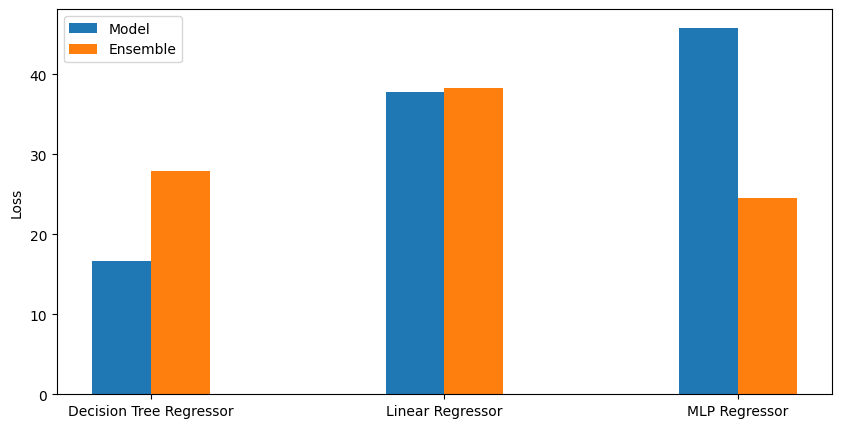

In [74]:
loss_model = []
loss_ensemble = []

base_estimator = DTR(max_depth=5, max_features=5, criterion='squared_error')
model = BaggingRegressor(base_estimator, 3, 1, True, 'hard')
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house, y_test_house_new)
loss_ensemble.append(mean_squared_error(y_test_house_new, predictions))

model = DTR(max_depth=5, max_features=5, criterion='squared_error')
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house)
loss_model.append(mean_squared_error(y_test_house_new, predictions))

base_estimator = LinearRegressor(0.01, 2000)
model = BaggingRegressor(base_estimator, 10, 0.5, True, 'hard')
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house, y_test_house_new)
loss_ensemble.append(mean_squared_error(y_test_house_new, predictions))

model = LinearRegressor(0.01, 2000)
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house)
loss_model.append(mean_squared_error(y_test_house_new, predictions))

base_estimator = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model = BaggingRegressor(base_estimator, 10, 0.5, True, 'hard')
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house, y_test_house_new)
loss_ensemble.append(mean_squared_error(y_test_house_new, predictions))

model = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model.fit(x_train_house, y_train_house_new)
predictions = model.predict(x_test_house)
loss_model.append(mean_squared_error(y_test_house_new, predictions))

plt.figure(figsize=(10, 5))
plt.bar(np.arange(3), loss_model, width=0.2, label='Model')
plt.bar(np.arange(3) + 0.2, loss_ensemble, width=0.2, label='Ensemble')
plt.xticks(np.arange(3) + 0.1, ['Decision Tree Regressor', 'Linear Regressor', 'MLP Regressor'])
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3.3

Stacking Classifier

In [13]:
class StackingClassifier:
    def __init__(self, level0_estimators, level1_estimator, num_classes, stacking_method, hold_out_ratio=None, k_folds=None):
        self.level0_estimators = level0_estimators
        self.level1_estimator = level1_estimator
        self.stacking_method = stacking_method
        self.hold_out_ratio = hold_out_ratio
        self.k_folds = k_folds
        self.num_classes = num_classes

    def fit(self, x, y):
        if self.stacking_method == 'blending':
            self.blending(x, y)
        else:
            self.stacking(x, y)

    def stacking(self, x, y):
        kf = KFold(n_splits=self.k_folds)
        dataset = np.zeros((x.shape[0], len(self.level0_estimators)))
        y_val = np.zeros((x.shape[0], self.num_classes))
        j = 0

        for train_index, test_index in kf.split(x):
            x_train, x_valid = x[train_index], x[test_index]
            y_train, y_valid = y[train_index], y[test_index]

            level0_predictions = np.zeros((x_valid.shape[0], len(self.level0_estimators)))
            
            for i in range(len(self.level0_estimators)):
                self.level0_estimators[i].fit(x_train, y_train)
                level0_predictions[:, i] = self.level0_estimators[i].predict2(x_valid)
                
            dataset[j * x_valid.shape[0] : (j + 1) * x_valid.shape[0], :] = level0_predictions
            y_val[j * x_valid.shape[0] : (j + 1) * x_valid.shape[0], :] = y_valid
            j += 1

        self.level1_estimator.fit(dataset, y_val)

        for i in range(len(self.level0_estimators)):
            self.level0_estimators[i].fit(x, y)

    def blending(self, x, y):
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=self.hold_out_ratio, random_state=42)   
        level0_predictions = np.zeros((x_valid.shape[0], len(self.level0_estimators)))

        dataset = np.zeros((x_valid.shape[0], len(self.level0_estimators)))

        for i in range(len(self.level0_estimators)):
            self.level0_estimators[i].fit(x_train, y_train)
            level0_predictions[:, i] = self.level0_estimators[i].predict2(x_valid)
            dataset[:, i] = level0_predictions[:, i]

        self.level1_estimator.fit(dataset, y_valid)        

    def predict(self, X):
        level0_predictions = np.zeros((X.shape[0], len(self.level0_estimators)))

        for i in range(len(self.level0_estimators)):
            level0_predictions[:, i] = self.level0_estimators[i].predict2(X)

        return level0_predictions
    
    def scores(self, X, y):
        predictions = self.predict(X)
        y = np.argmax(y, axis=1)
        pred = self.level1_estimator.predict2(predictions)

        acc = accuracy_score(y, pred)
        f1 = f1_score(y, pred, average='macro')
        precision = precision_score(y, pred, average='macro', zero_division=0)
        recall = recall_score(y, pred, average='macro', zero_division=0)
        
        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

Blending

In [138]:
print("Stacking Classifier with Blending:")
print()

print("Decision Tree Classifier as Level 1 Estimator")
level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = DTC(max_depth=5, max_features=5, criterion='entropy')
model = StackingClassifier(level0, level1, y_train_wine.shape[1], 'blending', hold_out_ratio=0.2)
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("Logistic Regressor as Level 1 Estimator")
level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = LogisticRegressor(y_train_wine.shape[1], 3, 0.01, 2000)
model = StackingClassifier(level0, level1, y_train_wine.shape[1], 'blending', hold_out_ratio=0.2)
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

Stacking Classifier with Blending:

Decision Tree Classifier as Level 1 Estimator
Validation scores: 
Accuracy:  0.5964912280701754
Precision:  0.354384236453202
Recall:  0.3373556352050976
F1 score:  0.3350305627618537
Test scores: 
Accuracy:  0.5813953488372093
Precision:  0.32013888888888886
Recall:  0.33890397184514837
F1 score:  0.32811039587393453

Logistic Regressor as Level 1 Estimator
Validation scores: 
Accuracy:  0.43859649122807015
Precision:  0.18243697478991597
Recall:  0.22907208283552366
F1 score:  0.1757924068268896
Test scores: 
Accuracy:  0.5290697674418605
Precision:  0.2045756119881034
Recall:  0.2338081671415005
F1 score:  0.19943693693693693


Stacking

In [139]:
print("Stacking Classifier with Stacking:")
print()

print("Decision Tree Classifier as Level 1 Estimator")
level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = DTC(max_depth=5, max_features=5, criterion='entropy')
model = StackingClassifier(level0, level1, y_train_wine.shape[1], 'stacking', k_folds=5)
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

print()

print("Logistic Regressor as Level 1 Estimator")
level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = LogisticRegressor(y_train_wine.shape[1], 3, 0.01, 2000)
model = StackingClassifier(level0, level1, y_train_wine.shape[1], 'stacking', k_folds=5)
model.fit(x_train_wine, y_train_wine)
print("Validation scores: ")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores: ")
model.scores(x_test_wine, y_test_wine)

Stacking Classifier with Stacking:

Decision Tree Classifier as Level 1 Estimator
Validation scores: 
Accuracy:  0.6081871345029239
Precision:  0.37596787148594374
Recall:  0.33699721226602947
F1 score:  0.34418531046624334
Test scores: 
Accuracy:  0.5930232558139535
Precision:  0.3260184359203092
Recall:  0.3456656052734484
F1 score:  0.3346434309726857

Logistic Regressor as Level 1 Estimator
Validation scores: 
Accuracy:  0.5906432748538012
Precision:  0.23852813852813853
Recall:  0.2804062126642772
F1 score:  0.2571572580645161
Test scores: 
Accuracy:  0.6104651162790697
Precision:  0.24462474645030427
Recall:  0.2866096866096866
F1 score:  0.262999365884591


In [79]:
level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], 3, 0.01, 2000)]
level1_names = ['Decision Tree Classifier', 'Logistic Regressor']
stacking_method = ['blending', 'stacking']
hold_out_ratio = [0.1, 0.2, 0.3]
k_folds = [3, 5, 7]

best_level1 = None
best_level1_name = None
best_stacking_method = None
best_hold_out_ratio = None
best_k_folds = None

best_acc = 0

for i in range(len(level0)):
    for j in range(len(level1)):
        for k in range(len(stacking_method)):
            if stacking_method[k] == 'blending':
                for l in range(len(hold_out_ratio)):
                    model = StackingClassifier(level0, level1[j], y_train_wine.shape[1], stacking_method[k], hold_out_ratio=hold_out_ratio[l])
                    model.fit(x_train_wine, y_train_wine)
                    predictions = model.predict(x_valid_wine)
                    y_valid_wine_new = np.argmax(y_valid_wine, axis=1)
                    pred = model.level1_estimator.predict2(predictions)
                    acc = accuracy_score(y_valid_wine_new, pred)
                    print(acc)

                    if acc > best_acc:
                        best_acc = acc
                        best_level1 = level1[j]
                        best_level1_name = level1_names[j]
                        best_stacking_method = stacking_method[k]
                        best_hold_out_ratio = hold_out_ratio[l]
                        best_k_folds = None
            else:
                for l in range(len(k_folds)):
                    model = StackingClassifier(level0, level1[j], y_train_wine.shape[1], stacking_method[k], k_folds=k_folds[l])
                    model.fit(x_train_wine, y_train_wine)
                    predictions = model.predict(x_valid_wine)
                    y_valid_wine_new = np.argmax(y_valid_wine, axis=1)
                    pred = model.level1_estimator.predict2(predictions)
                    acc = accuracy_score(y_valid_wine_new, pred)
                    print(acc)

                    if acc > best_acc:
                        best_acc = acc
                        best_level1 = level1[j]
                        best_level1_name = level1_names[j]
                        best_stacking_method = stacking_method[k]
                        best_k_folds = k_folds[l]
                        best_hold_out_ratio = None

print("Best level 1 estimator: ", best_level1_name)
print("Best stacking method: ", best_stacking_method)
print("Best hold out ratio: ", best_hold_out_ratio)
print("Best k folds: ", best_k_folds)

0.5906432748538012
0.5789473684210527
0.6198830409356725
0.6140350877192983
0.5497076023391813
0.5730994152046783
0.3567251461988304
0.5789473684210527
0.6023391812865497
0.5730994152046783
0.5847953216374269
0.5906432748538012
0.5906432748538012
0.5847953216374269
0.5906432748538012
0.5906432748538012
0.5906432748538012
0.5906432748538012
0.5789473684210527
0.6023391812865497
0.5672514619883041
0.5906432748538012
0.5906432748538012
0.5789473684210527
0.6023391812865497
0.5964912280701754
0.5906432748538012
0.5906432748538012
0.5906432748538012
0.5964912280701754
0.6081871345029239
0.5847953216374269
0.5789473684210527
0.5964912280701754
0.5906432748538012
0.5789473684210527
Best level 1 estimator:  Decision Tree Classifier
Best stacking method:  blending
Best hold out ratio:  0.3
Best k folds:  None


In [84]:
base_estimator = LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000)
model = BaggingClassifier(base_estimator, 7, 0.5, False, 'soft', y_train_wine.shape[1])
start = time.time()
model.fit(x_train_wine, y_train_wine)
end = time.time()
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
acc_bagging = accuracy_score(y_test_wine_new, predictions)
time_bagging = end - start

level0 = [DTC(max_depth=5, max_features=5, criterion='entropy'), LogisticRegressor(y_train_wine.shape[1], x_train_wine.shape[1], 0.01, 2000), MlpClassifier(x_train_wine.shape[1], y_train_wine.shape[1], 1, 0.1, 3000, 64, 'sigmoid', 'bgd', x_train_wine.shape[0])]
level1 = DTC(max_depth=5, max_features=5, criterion='entropy')
model = StackingClassifier(level0, level1, y_train_wine.shape[1], 'blending', hold_out_ratio=0.3)
start = time.time()
model.fit(x_train_wine, y_train_wine)
end = time.time()
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
pred = model.level1_estimator.predict2(predictions)
acc_stacking = accuracy_score(y_test_wine_new, pred)
time_stacking = end - start

print("Bagging Accuracy: ", acc_bagging)
print("Bagging Training Time: ", time_bagging)
print("Stacking Accuracy: ", acc_stacking)
print("Stacking Training Time: ", time_stacking)

Bagging Accuracy:  0.6046511627906976
Bagging Training Time:  0.7343168258666992
Stacking Accuracy:  0.5930232558139535
Stacking Training Time:  1.6423261165618896


- Training time of stacking ensemble is greater than that of bagging ensemble.
- Accuracies of both the ensembles are nearly the same

Stacking Regressor

In [14]:
class StackingRegressor:
    def __init__(self, level0_estimators, level1_estimator, stacking_method, hold_out_ratio=None, k_folds=None):
        self.level0_estimators = level0_estimators
        self.level1_estimator = level1_estimator
        self.stacking_method = stacking_method
        self.hold_out_ratio = hold_out_ratio
        self.k_folds = k_folds

    def fit(self, x, y):
        if self.stacking_method == 'blending':
            self.blending(x, y)
        else:
            self.stacking(x, y)

    def stacking(self, x, y):
        kf = KFold(n_splits=self.k_folds)
        dataset = np.zeros((x.shape[0], len(self.level0_estimators)))
        y_val = np.zeros((x.shape[0], 1))
        j = 0

        for train_index, test_index in kf.split(x):
            x_train, x_valid = x[train_index], x[test_index]
            y_train, y_valid = y[train_index], y[test_index]

            level0_predictions = np.zeros((x_valid.shape[0], len(self.level0_estimators)))
            
            for i in range(len(self.level0_estimators)):
                self.level0_estimators[i].fit(x_train, y_train)
                level0_predictions[:, i] = self.level0_estimators[i].predict(x_valid)
                
            dataset[j * x_valid.shape[0] : (j + 1) * x_valid.shape[0], :] = level0_predictions
            y_val[j * x_valid.shape[0] : (j + 1) * x_valid.shape[0], :] = y_valid
            j += 1

        self.level1_estimator.fit(dataset, y_val)

        for i in range(len(self.level0_estimators)):
            self.level0_estimators[i].fit(x, y)

    def blending(self, x, y):
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=self.hold_out_ratio, random_state=42)   
        level0_predictions = np.zeros((x_valid.shape[0], len(self.level0_estimators)))

        dataset = np.zeros((x_valid.shape[0], len(self.level0_estimators)))

        for i in range(len(self.level0_estimators)):
            self.level0_estimators[i].fit(x_train, y_train)
            level0_predictions[:, i] = self.level0_estimators[i].predict(x_valid)
            dataset[:, i] = level0_predictions[:, i]

        self.level1_estimator.fit(dataset, y_valid)

    def predict(self, X):
        level0_predictions = np.zeros((X.shape[0], len(self.level0_estimators)))

        for i in range(len(self.level0_estimators)):
            level0_predictions[:, i] = self.level0_estimators[i].predict(X)

        return level0_predictions
    
    def scores(self, X, y):
        predictions = self.predict(X)
        #print(predictions.shape, y.shape)
        pred = self.level1_estimator.predict(predictions)

        mse = mean_squared_error(y, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, pred)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

Blending

In [142]:
print("Stacking Regressor with Blending:")
print()

print("Decision Tree Regressor as Level 1 Estimator")
level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = DTR(max_depth=5, max_features=5, criterion='squared_error')
model = StackingRegressor(level0, level1, 'blending', hold_out_ratio=0.2)
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("Linear Regressor as Level 1 Estimator")
level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = LinearRegressor(0.01, 2000)
model = StackingRegressor(level0, level1, 'blending', hold_out_ratio=0.2)
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

Stacking Regressor with Blending:

Decision Tree Regressor as Level 1 Estimator
Validation scores: 
MSE:  37.82997125765597
RMSE:  6.150607389327981
R2 Score:  0.45466359573407
Test scores: 
MSE:  49.72370880167904
RMSE:  7.051504009903067
R2 Score:  0.3743821414849712

Linear Regressor as Level 1 Estimator
Validation scores: 
MSE:  20.491571478107563
RMSE:  4.526761698842514
R2 Score:  0.7046045890038066
Test scores: 
MSE:  28.63032062012268
RMSE:  5.350730849157214
R2 Score:  0.6397766718005758


Stacking

In [143]:
print("Stacking Regressor with Stacking:")
print()

print("Decision Tree Regressor as Level 1 Estimator")
level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = DTR(max_depth=5, max_features=5, criterion='squared_error')
model = StackingRegressor(level0, level1, 'stacking', k_folds=5)
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

print()

print("Linear Regressor as Level 1 Estimator")
level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = LinearRegressor(0.01, 2000)
model = StackingRegressor(level0, level1, 'stacking', k_folds=5)
model.fit(x_train_house, y_train_house_new)
print("Validation scores: ")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores: ")
model.scores(x_test_house, y_test_house_new)

Stacking Regressor with Stacking:

Decision Tree Regressor as Level 1 Estimator
Validation scores: 
MSE:  11.504410424807034
RMSE:  3.3918152108873847
R2 Score:  0.8341586417939963
Test scores: 
MSE:  31.067579373856454
RMSE:  5.573829865887229
R2 Score:  0.6091113686905544

Linear Regressor as Level 1 Estimator
Validation scores: 
MSE:  10.361431745824254
RMSE:  3.2189177910944315
R2 Score:  0.8506352042186359
Test scores: 
MSE:  28.301865190478487
RMSE:  5.319949735709773
R2 Score:  0.6439092594024222


In [88]:
level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000)]
level1_names = ['Decision Tree Regressor', 'Linear Regressor']
stacking_method = ['blending', 'stacking']
hold_out_ratio = [0.1, 0.2, 0.3]
k_folds = [3, 5, 7]

best_level1 = None
best_level1_name = None
best_stacking_method = None
best_hold_out_ratio = None
best_k_folds = None

best_loss = 100000

for i in range(len(level0)):
    for j in range(len(level1)):
        for k in range(len(stacking_method)):
            if stacking_method[k] == 'blending':
                for l in range(len(hold_out_ratio)):
                    model = StackingRegressor(level0, level1[j], stacking_method[k], hold_out_ratio=hold_out_ratio[l])
                    model.fit(x_train_house, y_train_house_new)
                    predictions = model.predict(x_valid_house)
                    pred = model.level1_estimator.predict(predictions)
                    loss = mean_squared_error(y_valid_house_new, pred)
                    print(loss)

                    if loss < best_loss:
                        best_loss = loss
                        best_level1 = level1[j]
                        best_level1_name = level1_names[j]
                        best_stacking_method = stacking_method[k]
                        best_hold_out_ratio = hold_out_ratio[l]
                        best_k_folds = None
            else:
                for l in range(len(k_folds)):
                    model = StackingRegressor(level0, level1[j], stacking_method[k], k_folds=k_folds[l])
                    model.fit(x_train_house, y_train_house_new)
                    predictions = model.predict(x_valid_house)
                    pred = model.level1_estimator.predict(predictions)
                    loss = mean_squared_error(y_valid_house_new, pred)
                    print(loss)

                    if loss < best_loss:
                        best_loss = loss
                        best_level1 = level1[j]
                        best_level1_name = level1_names[j]
                        best_stacking_method = stacking_method[k]
                        best_k_folds = k_folds[l]
                        best_hold_out_ratio = None

print("Best level 1 estimator: ", best_level1_name)
print("Best stacking method: ", best_stacking_method)
print("Best hold out ratio: ", best_hold_out_ratio)
print("Best k folds: ", best_k_folds)

36.40154956140351
35.24757212749134
51.68035956949454
12.835074215011632
8.491014958521731
12.801075988639237
12.240632093871275
11.881940704506562
10.541756173984211
9.406399697935896
9.734710402620122
12.51360115530951
27.143801169590645
30.01427148761822
19.77726485596432
9.63329098463933
11.718549319280992
12.50684088638672
9.856035931854933
8.680462732968785
7.909622628695077
7.977668106111867
9.20869479364134
8.125292341782108
16.455757351712617
14.374701951597592
10.429159108001645
9.903418878360045
8.87097998085073
9.368724354088027
9.7550449385254
6.011867796995695
5.884600063382917
6.969236233268657
7.774572908121421
9.183782328931827
Best level 1 estimator:  Linear Regressor
Best stacking method:  blending
Best hold out ratio:  0.3
Best k folds:  None


In [90]:
base_estimator = MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])
model = BaggingRegressor(base_estimator, 7, 0.75, True, 'hard')
start = time.time()
model.fit(x_train_house, y_train_house_new)
end = time.time()
predictions = model.predict(x_test_house, y_test_house_new)
loss_bagging = mean_squared_error(y_test_house_new, predictions)
time_bagging = end - start

level0 = [DTR(max_depth=5, max_features=5, criterion='squared_error'), LinearRegressor(0.01, 2000), MlpRegressor(x_train_house.shape[1], y_train_house_new.shape[1], 1, 0.001, 2000, 32, 'sigmoid', 'bgd', x_train_house.shape[0])]
level1 = LinearRegressor(0.01, 2000)
model = StackingRegressor(level0, level1, 'blending', hold_out_ratio=0.3)
start = time.time()
model.fit(x_train_house, y_train_house_new)
end = time.time()
predictions = model.predict(x_test_house)
pred = model.level1_estimator.predict(predictions)
loss_stacking = mean_squared_error(y_test_house_new, pred)
time_stacking = end - start

print("Bagging Loss: ", loss_bagging)
print("Bagging Training Time: ", time_bagging)
print("Stacking Loss: ", loss_stacking)
print("Stacking Training Time: ", time_stacking)

Bagging Loss:  22.99947368421053
Bagging Training Time:  1.7381129264831543
Stacking Loss:  21.39017849788322
Stacking Training Time:  0.290860652923584


- Training time of bagging ensemble is greater than that of stacking ensemble.
- Loss of both the ensembles are nearly the same

## 4

Random Forest Classifier

In [15]:
class RandomForestClassifier:
    def __init__(self, num_estimators, max_depth, max_features, criterion):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.features = []
        self.criterion = criterion
        self.estimators = []

    def fit(self, x, y):
      for i in range(self.num_estimators):
            indices = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
            x_train = x[indices]
            y_train = y[indices]

            self.max_features = np.random.randint(1, x.shape[1] + 1)
            self.features.append(np.random.choice(x.shape[1], size=self.max_features, replace=False))
            x_train = x_train[:, self.features[i]]

            estimator = DTC(self.max_depth, self.max_features, self.criterion)
            estimator.fit(x_train, y_train)

            self.estimators.append(estimator)

    def predict(self, x):
        predictions = np.zeros((x.shape[0], self.num_estimators))

        for i in range(self.num_estimators):
            predictions[:, i] = self.estimators[i].predict2(x[:, self.features[i]])

        predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=predictions)
        return predictions

    def scores(self, x, y):
        predictions = self.predict(x)
        y = np.argmax(y, axis=1)

        acc = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions, average='macro')
        precision = precision_score(y, predictions, average='macro', zero_division=0)
        recall = recall_score(y, predictions, average='macro', zero_division=0)
        
        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

In [147]:
print("Random Forest Classifier")
model = RandomForestClassifier(10, 5, 5, 'entropy')
model.fit(x_train_wine, y_train_wine)
print("Validation scores:")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores:")
model.scores(x_test_wine, y_test_wine)

Random Forest Classifier
Validation scores:
Accuracy:  0.5672514619883041
Precision:  0.4261415525114155
Recall:  0.29058144165671046
F1 score:  0.2741031120777956
Test scores:
Accuracy:  0.5523255813953488
Precision:  0.36107729762629337
Recall:  0.27947265515892966
F1 score:  0.28223022924273505


In [92]:
num_estimators = [3, 5, 7, 10]
max_depth = [3, 5, 7]
max_features = [3, 5, 7]
criterion = ['entropy', 'gini']

best_num_estimators = None
best_max_depth = None
best_max_features = None
best_criterion = None

best_acc = 0

for i in range(len(num_estimators)):
    for j in range(len(max_depth)):
        for k in range(len(max_features)):
            for l in range(len(criterion)):
                model = RandomForestClassifier(num_estimators[i], max_depth[j], max_features[k], criterion[l])
                model.fit(x_train_wine, y_train_wine)
                predictions = model.predict(x_valid_wine)
                y_valid_wine_new = np.argmax(y_valid_wine, axis=1)
                acc = accuracy_score(y_valid_wine_new, predictions)
                print(acc)

                if acc > best_acc:
                    best_acc = acc
                    best_num_estimators = num_estimators[i]
                    best_max_depth = max_depth[j]
                    best_max_features = max_features[k]
                    best_criterion = criterion[l]

print("Best number of estimators: ", best_num_estimators)
print("Best max depth: ", best_max_depth)
print("Best max features: ", best_max_features)
print("Best criterion: ", best_criterion)

0.6081871345029239
0.5497076023391813
0.6081871345029239
0.6023391812865497
0.5789473684210527
0.5672514619883041
0.5730994152046783
0.5672514619883041
0.5321637426900585
0.5497076023391813
0.543859649122807
0.5730994152046783
0.5146198830409356
0.4327485380116959
0.543859649122807
0.5497076023391813
0.5146198830409356
0.5672514619883041
0.6140350877192983
0.5263157894736842
0.5730994152046783
0.5789473684210527
0.5789473684210527
0.6198830409356725
0.6198830409356725
0.5730994152046783
0.5730994152046783
0.5906432748538012
0.5847953216374269
0.5555555555555556
0.5497076023391813
0.5789473684210527
0.5087719298245614
0.6081871345029239
0.5497076023391813
0.5555555555555556
0.6023391812865497
0.631578947368421
0.5906432748538012
0.5964912280701754
0.5789473684210527
0.5672514619883041
0.5906432748538012
0.6140350877192983
0.5146198830409356
0.6432748538011696
0.5847953216374269
0.6198830409356725
0.631578947368421
0.672514619883041
0.5672514619883041
0.5906432748538012
0.619883040935672

Random Forest Regressor

In [16]:
class RandomForestRegressor:
    def __init__(self, num_estimators, max_depth, max_features, criterion):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.features = []
        self.criterion = criterion
        self.estimators = []

    def fit(self, x, y):
      for i in range(self.num_estimators):
            indices = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
            x_train = x[indices]
            y_train = y[indices]

            self.max_features = np.random.randint(1, x.shape[1] + 1)
            self.features.append(np.random.choice(x.shape[1], size=self.max_features, replace=False))
            x_train = x_train[:, self.features[i]]

            estimator = DTR(self.max_depth, self.max_features, self.criterion)
            estimator.fit(x_train, y_train)

            self.estimators.append(estimator)

    def predict(self, x):
        predictions = np.zeros((x.shape[0], self.num_estimators))

        for i in range(self.num_estimators):
            predictions[:, i] = self.estimators[i].predict(x[:, self.features[i]])

        predictions = np.mean(predictions, axis=1)
        return predictions

    def scores(self, x, y):
        predictions = self.predict(x)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, predictions)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

In [149]:
print("Random Forest Regressor")
model = RandomForestRegressor(10, 5, 5, 'squared_error')
model.fit(x_train_house, y_train_house_new)
print("Validation scores:")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores:")
model.scores(x_test_house, y_test_house_new)

Random Forest Regressor
Validation scores:
MSE:  10.033396498658773
RMSE:  3.167553708883051
R2 Score:  0.855363982914853
Test scores:
MSE:  25.202088226475443
RMSE:  5.02016814723127
R2 Score:  0.6829102887469654


In [94]:
num_estimators = [3, 5, 7, 10]
max_depth = [3, 5, 7]
max_features = [3, 5, 7]
criterion = ['squared_error', 'absolute_error']

best_num_estimators = None
best_max_depth = None
best_max_features = None
best_criterion = None

best_loss = 100000

for i in range(len(num_estimators)):
    for j in range(len(max_depth)):
        for k in range(len(max_features)):
            for l in range(len(criterion)):
                model = RandomForestRegressor(num_estimators[i], max_depth[j], max_features[k], criterion[l])
                model.fit(x_train_house, y_train_house_new)
                predictions = model.predict(x_valid_house)
                loss = mean_squared_error(y_valid_house_new, predictions)
                print(loss)

                if loss < best_loss:
                    best_loss = loss
                    best_num_estimators = num_estimators[i]
                    best_max_depth = max_depth[j]
                    best_max_features = max_features[k]
                    best_criterion = criterion[l]

print("Best number of estimators: ", best_num_estimators)
print("Best max depth: ", best_max_depth)
print("Best max features: ", best_max_features)
print("Best criterion: ", best_criterion)

9.888339663956828
25.70585891812865
14.16628195230404
26.41298245614035
11.52880870524818
30.162697368421057
26.439584872603017
30.787357456140345
31.74725632395382
13.369411549707603
12.858279077650396
26.454119152046772
24.53226241368051
17.182185672514624
19.79994323651062
11.255964912280703
33.456325812134374
12.035047514619881
17.744669428575286
16.96397763157894
16.975442628897998
21.149119736842113
9.272882458943327
9.006003947368425
19.18982018579075
10.03658684210526
15.918323652883274
11.399799999999997
9.858018729654853
15.395047368421055
15.42750380135319
10.055968421052631
12.707722636659758
16.070915789473684
17.373591622896935
12.010268421052631
15.872071166382796
16.097007250268526
14.6082840704277
13.475379967776579
11.455974427713564
11.643789607948442
7.773904994891896
11.930671321160043
13.009223197712634
18.289500537056927
9.165258483049378
10.074388426423198
7.800403182231861
7.128253893662729
11.828300776425342
10.649421992481209
10.769320261891322
7.510079215896

Ada-Boost Classifier

In [17]:
class AdaBoostClassifier:
    def __init__(self, num_estimators, criterion):
        self.num_estimators = num_estimators
        self.criterion = criterion
        self.estimators = []
        self.features = []

    def fit(self, x, y):
        weights = np.ones(x.shape[0]) / x.shape[0]

        for i in range(self.num_estimators):
            indices = np.random.choice(x.shape[0], size=x.shape[0], replace=True, p=weights)
            x_train = x[indices]
            y_train = y[indices]

            min_error = np.inf
            best_stump = None
            best_predictions = None
            feature = None

            for j in range(x_train.shape[1]):
                stump = DTC(1, 1, self.criterion)
                
                stump.fit(x_train[:, j].reshape(-1, 1), y_train)
                predictions = stump.predict2(x_train[:, j].reshape(-1, 1))
                error = np.sum(weights * (predictions != np.argmax(y_train, axis=1)))

                if error < min_error:
                    min_error = error
                    best_stump = stump
                    best_predictions = predictions
                    feature = j

            alpha = 0.5 * np.log((1 - min_error) / min_error)
            self.features.append(feature)

            for j in range(x_train.shape[0]):
                if best_predictions[j] == np.argmax(y_train[j]):
                    weights[j] *= np.exp(alpha)
                else:
                    weights[j] *= np.exp(-alpha)

            weights /= np.sum(weights)
            self.estimators.append(best_stump)

    def predict(self, x):
        predictions = np.zeros((x.shape[0], self.num_estimators))

        for i in range(self.num_estimators):
            predictions[:, i] = self.estimators[i].predict2(x[:, self.features[i]].reshape(-1, 1))

        predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=predictions)
        return predictions

    def scores(self, x, y):
        predictions = self.predict(x)
        y = np.argmax(y, axis=1)

        acc = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions, average='macro')
        precision = precision_score(y, predictions, average='macro', zero_division=0)
        recall = recall_score(y, predictions, average='macro', zero_division=0)
        
        print('Accuracy: ', acc)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 score: ', f1)

In [21]:
print("AdaBoost Classifier")
model = AdaBoostClassifier(10, 'entropy')
model.fit(x_train_wine, y_train_wine)
print("Validation scores:")
model.scores(x_valid_wine, y_valid_wine)
print("Test scores:")
model.scores(x_test_wine, y_test_wine)

AdaBoost Classifier
Validation scores:
Accuracy:  0.5497076023391813
Precision:  0.2207300083588743
Recall:  0.2714456391875747
F1 score:  0.2392047068370866
Test scores:
Accuracy:  0.5581395348837209
Precision:  0.21415607985480944
Recall:  0.25344729344729344
F1 score:  0.229343339587242


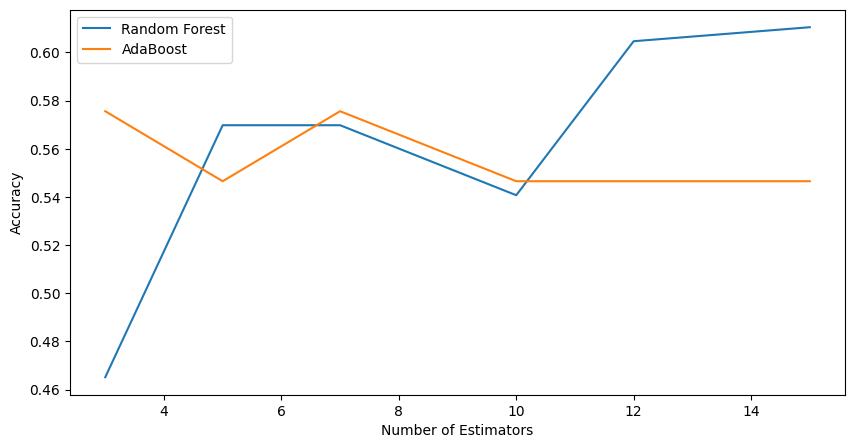

In [97]:
num_estimators = [3, 5, 7, 10, 12, 15]

rf_acc = []
ab_acc = []

for i in range(len(num_estimators)):
    model = RandomForestClassifier(num_estimators[i], 7, 3, 'gini')
    model.fit(x_train_wine, y_train_wine)
    predictions = model.predict(x_test_wine)
    y_test_wine_new = np.argmax(y_test_wine, axis=1)
    acc = accuracy_score(y_test_wine_new, predictions)
    rf_acc.append(acc)

    model = AdaBoostClassifier(num_estimators[i], 'entropy')
    model.fit(x_train_wine, y_train_wine)
    predictions = model.predict(x_test_wine)
    y_test_wine_new = np.argmax(y_test_wine, axis=1)
    acc = accuracy_score(y_test_wine_new, predictions)
    ab_acc.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(num_estimators, rf_acc, label='Random Forest')
plt.plot(num_estimators, ab_acc, label='AdaBoost')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

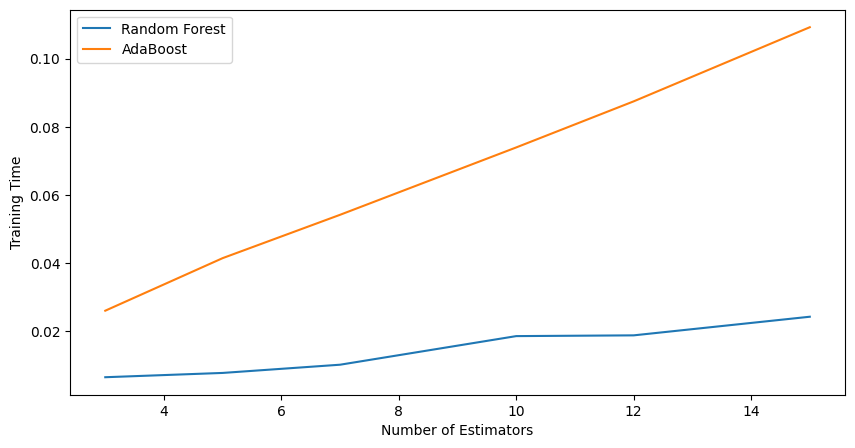

In [98]:
num_estimators = [3, 5, 7, 10, 12, 15]

rf_time = []
ab_time = []

for i in range(len(num_estimators)):
    model = RandomForestClassifier(num_estimators[i], 7, 3, 'gini')
    start = time.time()
    model.fit(x_train_wine, y_train_wine)
    end = time.time()
    rf_time.append(end - start)

    model = AdaBoostClassifier(num_estimators[i], 'entropy')
    start = time.time()
    model.fit(x_train_wine, y_train_wine)
    end = time.time()
    ab_time.append(end - start)

plt.figure(figsize=(10, 5))
plt.plot(num_estimators, rf_time, label='Random Forest')
plt.plot(num_estimators, ab_time, label='AdaBoost')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time')
plt.legend()
plt.show()

Ada-Boost Regressor

In [86]:
class AdaBoostRegressor:
    def __init__(self, num_estimators, criterion):
        self.num_estimators = num_estimators
        self.criterion = criterion
        self.estimators = []
        self.beta = []
        self.features = []

    def fit(self, x, y):
        weights = np.ones(x.shape[0]) / x.shape[0]
        weights = weights.reshape(-1, 1)

        for i in range(self.num_estimators):
            indices = np.random.choice(x.shape[0], size=x.shape[0], replace=True, p=weights.reshape(-1))
            x_train = x[indices]
            y_train = y[indices]

            min_error = np.inf
            best_stump = None
            best_predictions = None
            feature = None

            for j in range(x_train.shape[1]):
                stump = DTR(1, 1, self.criterion)
                
                stump.fit(x_train[:, j].reshape(-1, 1), y_train)
                predictions = stump.predict(x_train[:, j].reshape(-1, 1)).reshape(-1, 1)
                #print(predictions.shape, y_train.shape)
                error = np.sum(weights * (np.abs(predictions - y_train)) / np.max(np.abs(y_train - predictions)))

                if error < min_error:
                    min_error = error
                    best_stump = stump
                    best_predictions = predictions
                    feature = j

            beta = np.log((1 - min_error) / min_error)
            
            weights *= np.exp(beta * (1 - (np.abs(y_train - best_predictions) / np.max(np.abs(y_train - best_predictions)))))
            weights /= np.sum(weights)
            self.beta.append(beta)
            self.features.append(feature)
            self.estimators.append(best_stump)

    def predict(self, x):
        predictions = np.zeros((x.shape[0], self.num_estimators))

        for i in range(self.num_estimators):
            predictions[:, i] = self.estimators[i].predict(x[:, self.features[i]].reshape(-1, 1))

        predictions = np.sum(predictions * self.beta, axis=1)
        return predictions

    def scores(self, x, y):
        predictions = self.predict(x)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, predictions)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

Gradient-Boosting Regressor

In [125]:
class GradientBoostingRegressor:
    def __init__(self, num_estimators, max_depth, max_features, criterion, learning_rate):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.features = []
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.estimators = []

    def fit(self, x, y):
        y_pred = np.mean(y) * np.ones(y.shape[0])
        y_pred = y_pred.reshape(-1, 1)

        for i in range(self.num_estimators):
            y_residual = y - y_pred
            estimator = DTR(self.max_depth, self.max_features, self.criterion)
            estimator.fit(x, y_residual)

            y_pred += self.learning_rate * estimator.predict(x).reshape(-1, 1)
            self.estimators.append(estimator)

    def predict(self, x, y):
        y_pred = np.mean(y) * np.ones(y.shape[0])

        for i in range(self.num_estimators):
            y_pred += self.learning_rate * self.estimators[i].predict(x)

        return y_pred

    def scores(self, x, y):
        predictions = self.predict(x, y)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, predictions)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

In [129]:
print("Gradient Boosting Regressor")
model = GradientBoostingRegressor(10, 5, 5, 'squared_error', 0.01)
model.fit(x_train_house, y_train_house_new)
print("Validation scores:")
model.scores(x_valid_house, y_valid_house_new)
print("Test scores:")
model.scores(x_test_house, y_test_house_new)

Gradient Boosting Regressor
Validation scores:
MSE:  58.856579787893345
RMSE:  7.671804206827319
R2 Score:  0.15155537998393542
Test scores:
MSE:  69.67197704440132
RMSE:  8.346974125058813
R2 Score:  0.12339537561697844


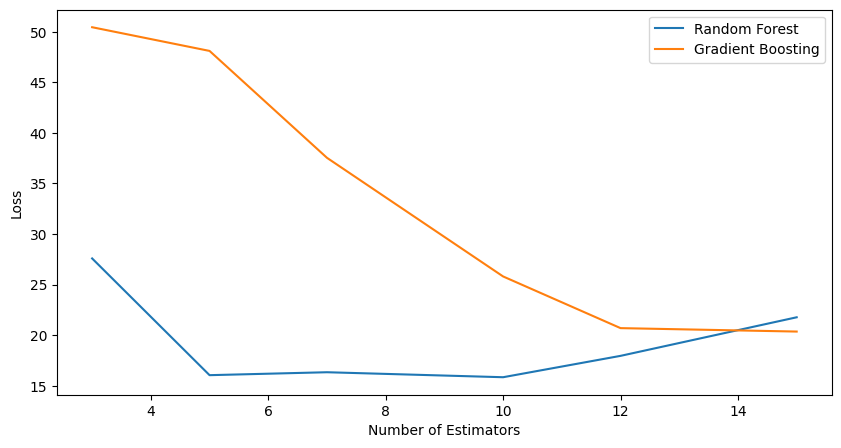

In [100]:
num_estimators = [3, 5, 7, 10, 12, 15]

rf_loss = []
gb_loss = []

for i in range(len(num_estimators)):
    model = RandomForestRegressor(num_estimators[i], 7, 3, 'absolute_error')
    model.fit(x_train_house, y_train_house_new)
    predictions = model.predict(x_test_house)
    loss = mean_squared_error(y_test_house_new, predictions)
    rf_loss.append(loss)

    model = GradientBoostingRegressor(num_estimators[i], 5, 5, 'squared_error', 0.1)
    model.fit(x_train_house, y_train_house_new)
    predictions = model.predict(x_test_house, y_test_house_new)
    loss = mean_squared_error(y_test_house_new, predictions)
    gb_loss.append(loss)

plt.figure(figsize=(10, 5))
plt.plot(num_estimators, rf_loss, label='Random Forest')
plt.plot(num_estimators, gb_loss, label='Gradient Boosting')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.legend()
plt.show()

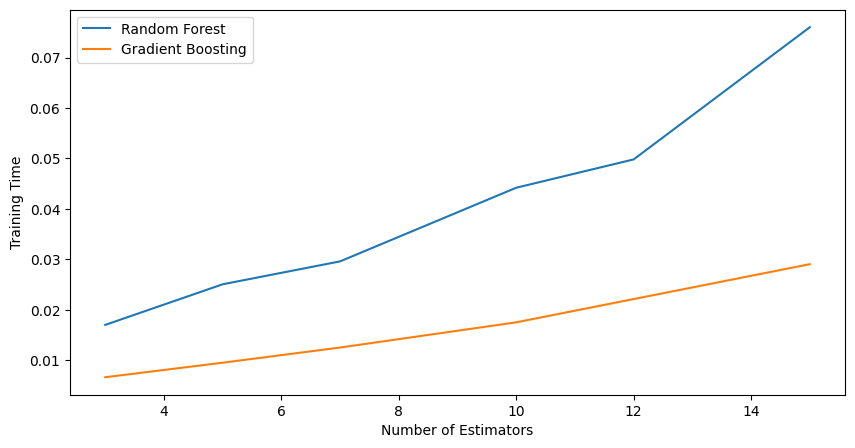

In [107]:
num_estimators = [3, 5, 7, 10, 12, 15]

rf_time = []
gb_time = []

for i in range(len(num_estimators)):
    model = RandomForestRegressor(num_estimators[i], 7, 3, 'absolute_error')
    start = time.time()
    model.fit(x_train_house, y_train_house_new)
    end = time.time()
    rf_time.append(end - start)

    model = GradientBoostingRegressor(num_estimators[i], 5, 5, 'squared_error', 0.01)
    start = time.time()
    model.fit(x_train_house, y_train_house_new)
    end = time.time()
    gb_time.append(end - start)

plt.figure(figsize=(10, 5))
plt.plot(num_estimators, rf_time, label='Random Forest')
plt.plot(num_estimators, gb_time, label='Gradient Boosting')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time')
plt.legend()
plt.show()

Random Forests vs Boosted Trees

In [94]:
def misclassification(y_true, y_pred):
    return np.where(y_true != y_pred)[0]

model = RandomForestClassifier(7, 7, 3, 'gini')
model.fit(x_train_wine, y_train_wine)
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
rf_misclassifications = misclassification(y_test_wine_new, predictions)
print("No of misclassifications for Random Forest Classifier: ", rf_misclassifications.shape[0])

model = AdaBoostClassifier(10, 'entropy')
model.fit(x_train_wine, y_train_wine)
predictions = model.predict(x_test_wine)
y_test_wine_new = np.argmax(y_test_wine, axis=1)
ab_misclassifications = misclassification(y_test_wine_new, predictions)
print("No of misclassifications for AdaBoost Classifier: ", ab_misclassifications.shape[0])

# get the common misclassifications for both the classifiers
common_misclassifications = np.intersect1d(rf_misclassifications, ab_misclassifications)
print("No of common misclassifications: ", common_misclassifications.shape[0])

No of misclassifications for Random Forest Classifier:  67
No of misclassifications for AdaBoost Classifier:  75
No of common misclassifications:  50


- Random forests work better than boosted trees in terms of classification

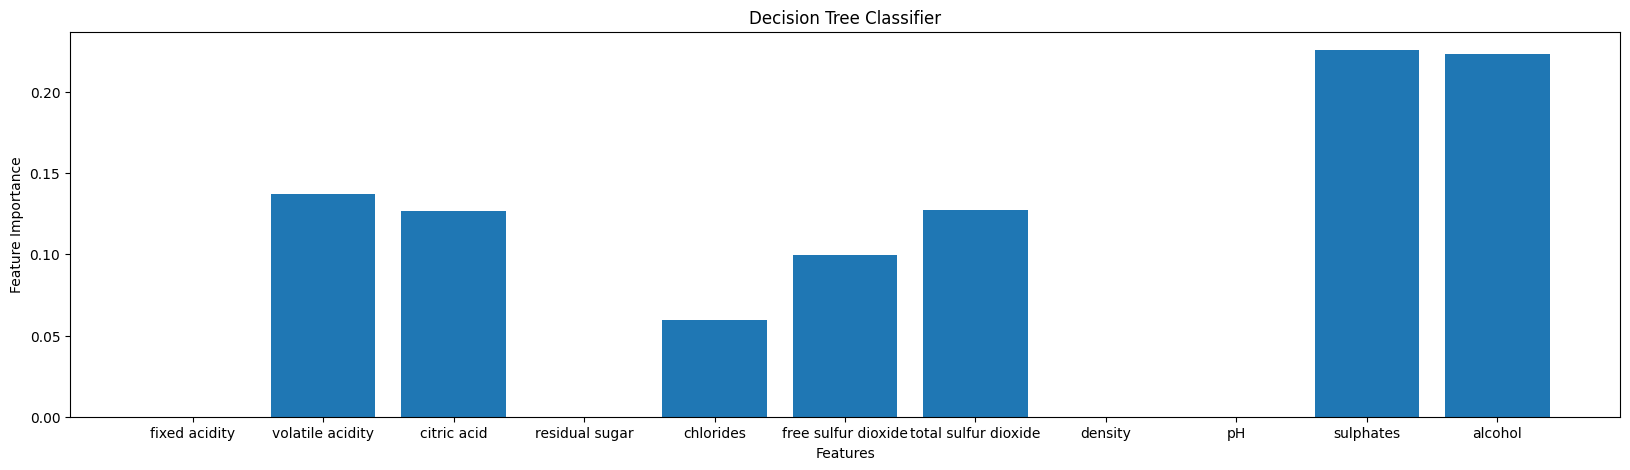

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x_train_wine[common_misclassifications], y_train_wine[common_misclassifications], test_size=0.2, random_state=42)

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
 
plt.figure(figsize=(20, 5))
plt.bar(feature_names, dtc.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Decision Tree Classifier')
plt.show()

Feature importance is highest for the mistakes in sulphates and alcohol. From this we can observe that, decision tree classifier is not able to classify properly based on the features: sulphates, alcohols. It is not able to capture the non-linearity present in them.